In [55]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [56]:
import numpy as np
import pandas as pd

In [57]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [58]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [59]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [60]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [61]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [62]:
#Explore the Database
inspector = inspect(engine)
inspector.get_table_names()

# Obtain columns and date type of tables
columns = inspector.get_columns('Measurement')
for c in columns:
        print (c['name'], c['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [63]:
inspector = inspect(engine)
inspector.get_table_names()

# Obtain columns and date type of tables
columns = inspector.get_columns('Station')
for c in columns:
        print (c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [64]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [65]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [66]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [67]:
#last month date
last_date_dt = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
last_twelve_month_date = last_date_dt - dt.timedelta(days=365)
last_twelve_month_date


datetime.datetime(2016, 8, 23, 0, 0)

In [68]:
# Perform a query to retrieve the date and precipitation scores

prcp_scores = session.query(Measurement.date, func.avg(Measurement.prcp))\
.filter(Measurement.date >= last_twelve_month_date)\
.group_by(Measurement.date)\
.all()
prcp_scores


[('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05),
 ('2016-09-03', 0.254),
 ('2016-09-04', 0.276),
 ('2016-09-05', 0.08499999999999999),
 ('2016-09-06', 0.246),
 ('2016-09-07', 0.3333333333333333),
 ('2016-09-08', 0.07666666666666667),
 ('2016-09-09', 0.17833333333333332),
 ('2016-09-10', 0.27999999999999997),
 ('2016-09-11', 0.25),
 ('2016-09-12', 0.308),
 ('2016-09-13', 0.45166666666666666),
 ('2016-09-14', 2.3800000000000003),
 ('2016-09-15', 0.8266666666666667),
 ('2016-09-16', 0.11714285714285715),
 ('2016-09-17', 0.13599999999999998),
 ('2016-09-18', 0.10600000000000001),
 ('2016-09-19', 0.064),
 ('2016-09-20', 0.14714285714285716),
 ('2016-09-21', 0.19499999999999998),
 ('2016-09-22', 

In [69]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_scores, columns=['Date', 'Precipitation'])
df.head()


,Date,Precipitation
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


In [70]:
# Sort the dataframe by ascending by date
df = df.sort_index(ascending = True)
df.head()

,Date,Precipitation
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


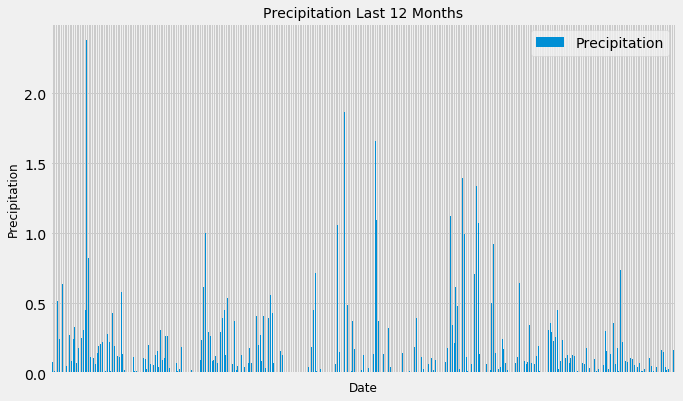

In [72]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot.bar(figsize=(10,6))
ax.axes.get_xaxis().set_ticklabels([])
#plt.grid(True)
plt.legends = []
plt.title("Precipitation Last 12 Months", size=14)
plt.ylabel("Precipitation", size=12)
plt.xlabel("Date", size=12)
plt.savefig("Output/PrcpLast12Months.png")
plt.show()


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [19]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()


9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()

active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station = active_station[0][0]

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
.filter(Measurement.station == most_active_station).all()


[(54.0, 85.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_highest_scores = session.query(Measurement.station, Measurement.tobs)\
.filter(Measurement.station == most_active_station)\
.filter(Measurement.date >= last_twelve_month_date)\
.all()

tobs_df = pd.DataFrame(tobs_highest_scores)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


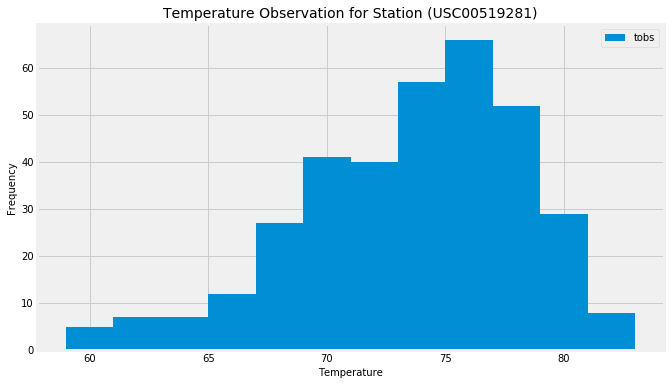

In [52]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_df.plot.hist(by='station', bins=12, figsize=(10,6))
ax.axes.get_xaxis().set_ticklabels([])
#plt.grid(True)
plt.legends = []
plt.title("Temperature Observation for Station (USC00519281)", size=14)
plt.ylabel("Frequency", size=10)
plt.xlabel("Temperature", size=10)
plt.savefig("Output/TempratureObsStation.png")
plt.show()




In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
#My trip dates
trip_start_date = '2017-07-20'
trip_end_date = '2017-07-29'

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
trip_avg_temp = calc_temps(trip_start_date, trip_end_date)
trip_avg_temp


# for your trip using the previous year's data for those same dates.


[(72.0, 78.66153846153846, 84.0)]

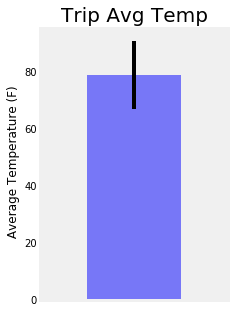

In [51]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# Build the plot

trip_df = pd.DataFrame(trip_avg_temp, columns=['TMIN', 'TAVG', 'TMAX'])
avg_temp = trip_df['TAVG']
min_max_temp = trip_df.iloc[0]['TMAX'] - trip_df.iloc[0]['TMIN']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(3,5), alpha=0.5, color='blue')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel(" Average Temperature (F)")
plt.xticks([])
plt.grid()
plt.savefig("Output/TripTempSummary.png")
plt.show()

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
total_rainfall = session.query(Measurement.station, func.sum(Measurement.prcp))\
                       .filter(Measurement.date>=trip_start_date).filter(Measurement.date<=trip_end_date)\
                       .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()  
total_rainfall



[('USC00516128', 7.739999999999999),
 ('USC00514830', 1.6800000000000002),
 ('USC00519281', 1.6600000000000001),
 ('USC00513117', 1.1099999999999999),
 ('USC00519523', 0.38),
 ('USC00519397', 0.11),
 ('USC00517948', 0.01)]

In [28]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_by_prcp = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation)\
                               .filter(Measurement.station==Station.station)\
                               .filter(Measurement.date>=trip_start_date).filter(Measurement.date<=trip_end_date)\
                               .group_by(Measurement.station)\
                               .order_by(func.sum(Measurement.prcp).desc()).all()
                                      
df = pd.DataFrame(rainfall_by_prcp, columns=['Station', 'Name', 'Total Precipitaion', 'Latitude','Longitude', 'Elevation'])
df.head()

,Station,Name,Total Precipitaion,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",7.74,21.33310,-157.80250,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.68,21.52130,-157.83740,7.0
2,USC00519281,"WAIHEE 837.5, HI US",1.66,21.45167,-157.84889,32.9
3,USC00513117,"KANEOHE 838.1, HI US",1.11,21.42340,-157.80150,14.6
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.38,21.33556,-157.71139,19.5


## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [42]:
# calculate the daily normals for your trip
#daily_normals("07-20")
# print(start_date)
# print(end_date)

# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = dt.datetime.strptime(trip_start_date, '%Y-%m-%d')
end_date = dt.datetime.strptime(trip_end_date, '%Y-%m-%d')

# Use the start and end date to create a range of dates
for n in range(int ((end_date - start_date).days)):
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
        dt_q = start_date + dt.timedelta(n)
#         print(dt_q)
        dt_query = dt_q.strftime("%m-%d")
#         print(dt_query)
        resultFromFunc = daily_normals(dt_query)
#         print(resultFromFunc[0])
        normals.append(resultFromFunc[0])
# print(type(normals))
normals


[(69.0, 75.46296296296296, 82.0),
 (69.0, 76.9245283018868, 83.0),
 (69.0, 75.78846153846153, 81.0),
 (70.0, 76.20370370370371, 84.0),
 (69.0, 76.55555555555556, 81.0),
 (67.0, 76.89090909090909, 84.0),
 (71.0, 76.4423076923077, 86.0),
 (68.0, 76.58181818181818, 83.0),
 (69.0, 76.46428571428571, 82.0)]

In [43]:
df_normals = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df_normals.head()

,tmin,tavg,tmax
0,69.0,75.462963,82.0
1,69.0,76.924528,83.0
2,69.0,75.788462,81.0
3,70.0,76.203704,84.0
4,69.0,76.555556,81.0


In [45]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` indexdf_normals = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])

df_normals['index1'] = df_normals.index
df_normals['Date'] = dt.datetime.strptime(trip_start_date, '%Y-%m-%d')
for (index_label, row_series) in df_normals.iterrows():
      df_normals.at[row_series['index1'], 'Date'] = row_series['Date'] + dt.timedelta(row_series['index1'])   

df_normals.drop(columns=['index1'], inplace=True)

df_normals.set_index('Date', inplace=True)
df_normals.head()

,tmin,tavg,tmax
Date,,,
2017-07-20,69.0,75.462963,82.0
2017-07-21,69.0,76.924528,83.0
2017-07-22,69.0,75.788462,81.0
2017-07-23,70.0,76.203704,84.0
2017-07-24,69.0,76.555556,81.0


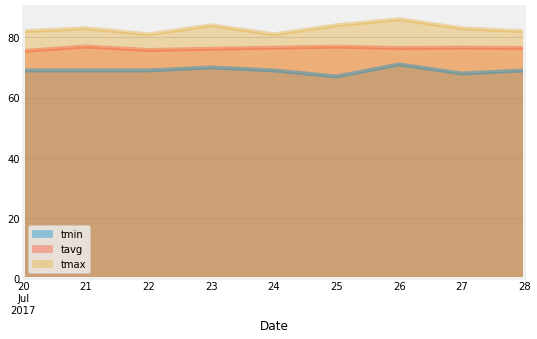

In [50]:
# Plot the daily normals as an area plot with `stacked=False`

df_normals.plot(kind='area', stacked=False, alpha=0.4,
        title='', figsize=(8,5))
plt.savefig("Output/DailyNormalsVacation.png")

